# Optimizacija kolonijom mrava (Ant Colony Optimization, ACO)

Mravi u prirodi pronalaze najkraći put od mravinjaka do hrane.

![images/ants.png](images/ants.png)

U prisustvu prepreke kao na slici, neki mravi su na početku išli sa gornje, a neki sa donje strane prepreke.
Nakon nekog vremena svi su počeli da idu sa gornje strane jer je taj put kraći.
Interesantno je da mravi nisu direktno komunicirali da bi jedni drugima rekli koji je put kraći.
Dok se kreću ostavljaju feromone po podlozi, a svaki mrav bira put na kome ima više feromona.
Feromoni tokom vremena isparavaju, pa što je put duži, to oni imaju više vremena da ispare.
Pritom, svaki mrav se ponaša na isti način - nema "tvrdoglavih" koji će nastaviti da idu dužim putem iako su možda njime išli na početku.

Najprirodnija primena ACO algoritma je za pronalaženje nekakvog najkraćeg puta u grafu.
Naravno, nećemo koristiti optimizacioni algoritam za nalaženje najkraćeg puta između dva čvora jer za tako nešto postoje egzaktni algoritmi polinomske složenosti.
Koristićemo ga za NP teške probleme, kao što je problem trgovačkog putnika (TSP).

Kod problema trgovačkog putnika cilj je pronaći najkraći Hamiltonov ciklus, odnosno put koji obilazi sve čvorove tačno jednom i na kraju se vraća u početni čvor.

In [30]:
import networkx as nx
import math
import random

In [31]:
def euclid_distance(u_x: float,
                    u_y: float,
                    v_x: float,
                    v_y: float) -> float:
    return math.sqrt((u_x - v_x)**2 + (u_y - v_y)**2)

In [32]:
def read_instance(file_path: str) -> nx.Graph:
    """Read data in the TSPLIB format and return a networkx Graph"""
    with open(file_path, 'r') as f:
        g = nx.Graph()
        for line in f:
            if line[0].isdigit():
                node_id, x, y = [float(a) for a in line.split()]
                # svaki čvor u grafu ima svoj id - obavezan parametar, a možemo da dodamo i proizvoljne atribute - u ovom slučaju x i y koordinate gradova
                g.add_node(int(node_id) - 1, x=x, y=y)
        
        # graf je potpun - imamo granu između svaka dva čvora
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                # računamo težinu grane kao evklidsko rastojanje između čvorova
                weight = euclid_distance(g.nodes[u]['x'],
                                        g.nodes[u]['y'],
                                        g.nodes[v]['x'],
                                        g.nodes[v]['y'])
                # slično kao i za čvorove, grane mogu da imaju proizvoljne atribute - u ovom slučaju težinu i feromone
                g.add_edge(u, v,
                           weight=weight,
                           pheromones=0.1)
                        #    pheromones=random.uniform(1e-3, 1e-2))
        
        return g

Test instance sa gradovima u državama - [link](https://www.math.uwaterloo.ca/tsp/world/countries.html)

In [33]:
g = read_instance(file_path='dj38.tsp')

In [34]:
g[0]

AtlasView({1: {'weight': 290.99301545433866, 'pheromones': 0.1}, 2: {'weight': 794.0018312710164, 'pheromones': 0.1}, 3: {'weight': 628.7062892741252, 'pheromones': 0.1}, 4: {'weight': 850.0494347752532, 'pheromones': 0.1}, 5: {'weight': 806.3010169484456, 'pheromones': 0.1}, 6: {'weight': 881.9759098638978, 'pheromones': 0.1}, 7: {'weight': 972.873183452112, 'pheromones': 0.1}, 8: {'weight': 991.2811948915838, 'pheromones': 0.1}, 9: {'weight': 437.07375847296123, 'pheromones': 0.1}, 10: {'weight': 1237.9197337359349, 'pheromones': 0.1}, 11: {'weight': 1186.9678817276742, 'pheromones': 0.1}, 12: {'weight': 903.3931728506114, 'pheromones': 0.1}, 13: {'weight': 507.7926916725464, 'pheromones': 0.1}, 14: {'weight': 903.1807647058093, 'pheromones': 0.1}, 15: {'weight': 1178.8418412907574, 'pheromones': 0.1}, 16: {'weight': 1197.2193112261596, 'pheromones': 0.1}, 17: {'weight': 1201.2191072966534, 'pheromones': 0.1}, 18: {'weight': 1205.3779366004712, 'pheromones': 0.1}, 19: {'weight': 901.

In [35]:
import random

In [36]:
def traverse(
    g: nx.Graph,
    start_node: int,
    alpha: float,
    beta: float,
):
    """
    Traverse the graph starting from the start_node and return the cycle and its weight - immitates the behavior of a single ant
    """
    cycle = [start_node]
    cycle_weight = 0
    visited = {start_node}
    u = start_node
    while len(visited) != len(g.nodes):
        neighbors = [v for v in g[u] if v not in visited]
        # biramo sledeći čvor na osnovu feromona i težine grane
        # više feromona => veća verovatnoća grane
        # manja težina => veća verovatnoća grane
        # alpha i beta su parametri koji određuju koliko će koji faktor uticati na izbor sledećeg čvora
        values = [g[u][v]['pheromones']**alpha / g[u][v]['weight']**beta for v in neighbors]
        chosen_neighbor = random.choices(neighbors, weights=values, k=1)[0]
        cycle.append(chosen_neighbor)
        visited.add(chosen_neighbor)
        cycle_weight += g[u][chosen_neighbor]['weight']
        u = chosen_neighbor
        
    # vraćamo se u početni čvor i dodajemo težinu grane između početnog i poslednjeg čvora
    cycle_weight += g[start_node][cycle[-1]]['weight']
    return cycle, cycle_weight

In [37]:
from matplotlib import pyplot as plt
from copy import deepcopy

In [38]:
def aco(
    g: nx.Graph,
    num_ants: int,
    rho: float,
    num_iters: int,
    theta: float,
    alpha: float,
    beta:float,
):
    
    best_cycle_lens = []
    final_cycle = None
    for i in range(num_iters):
        cycles = [traverse(g, start_node=0, alpha=alpha, beta=beta) for _ in range(num_ants)]
        
        # smanjivanje feromona - "isparavanje"
        for u in range(len(g.nodes)):
            for v in range(u + 1, len(g.nodes)):
                g[u][v]['pheromones'] *= rho

        # dodavanje feromona
        for cycle, cycle_weight in cycles:
            # svaki mrav dodaje feromone na svaku granu koja je deo ciklusa koji je on obišao
            # količina feromona je obrnuto srazmerna dužini ciklusa - što je ciklus kraći, to je veća količina feromona
            delta = theta / cycle_weight # TODO za domaći theta se smanjuje kroz iteracije
            for u, v in zip(cycle[:-1], cycle[1:]):
                g[u][v]['pheromones'] += delta
            g[cycle[0]][cycle[-1]]['pheromones'] += delta
            
        best_cycle = min(cycles, key=lambda c: c[1])
        best_cycle_lens.append(best_cycle[1])
        if final_cycle is None or best_cycle[1] < final_cycle[1]:
            final_cycle = deepcopy(best_cycle)
    
    plt.plot(range(num_iters), best_cycle_lens)
    print(final_cycle[0])
    print(final_cycle[1])

[0, 1, 3, 2, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 12, 14, 19, 22, 24, 25, 21, 23, 27, 26, 30, 35, 33, 32, 37, 36, 34, 31, 29, 28, 20, 9, 13]
6753.6758977961945


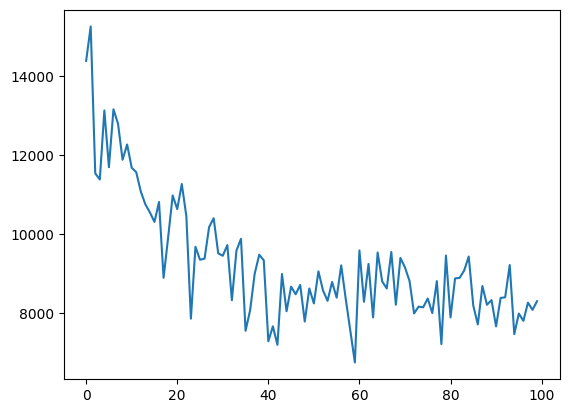

In [39]:
g = read_instance(file_path='dj38.tsp')
aco(g=g, num_ants=10, rho=0.9, num_iters=100, alpha=0.9, beta=1.5, theta=100.0)